In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer, AerSimulator

In [2]:
def nXOR(qc, qubits, output):
    for q in qubits:
        qc.cx(q, output)
    qc.barrier()

def XOR1(qc, a, output):
    qc.cx(a, output)
    qc.barrier()

def get_phase_gate(n):
    size = 2**n
    i = -np.eye(size)
    i[0][0] = 1
    phase_gate = UnitaryGate(i)
    return phase_gate

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for q in range(n):
        qc.h(q)
    qc.append(get_phase_gate(n), range(n))
    for q in range(n):
        qc.h(q)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [4]:
def generate_clause_list(A, n):
    clause_list = []
    
    for i in range(n):
        l = []
        for j in range(n):
            if A.item((i, j)) == 1:
                l.append(j)
        clause_list.append(l)
    
    return clause_list

In [5]:
def lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list):
    
    qc.barrier()
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.mcx(eq_qubits, sol_qubit)
    
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.barrier()
    
    qc.append(diffuser(n), range(n))
    

In [6]:
def lights_out_solver(A, p, n, t, init_distribution):
    var_qubits = QuantumRegister(n, name='click')
    p_qubits = QuantumRegister(n, name='initial')
    eq_qubits = QuantumRegister(n, name='output')  
    sol_qubit = QuantumRegister(1, name='solution')
    c_bits = ClassicalRegister(n, name='classical')
    
    clause_list = generate_clause_list(A, n)
    qc = QuantumCircuit(var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits)
    
    # INITIALIZATION
    # - STATE on SOLUTION QUBIT
    qc.x(sol_qubit)
    qc.h(sol_qubit)
    
    # Initial state to solve
    # For n nodes => Light is on/off => p
    for i in range(n):
        if p[i] == 1:
            qc.x(p_qubits[i])
    
    
    # SUPERPOSITION OF BITSTRING WITH INITIAL DISTRIBUTION
    qc.initialize(init_distribution, var_qubits)
    
    for i in range(t):
        lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list)
    
    for i in range(n):
        qc.measure(var_qubits[i], c_bits[i])
    
    return qc

In [7]:
A = np.matrix([[1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 0., 1., 1., 0., 0., 1., 1.]])
print(A)

[[1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]]


RANK :  6


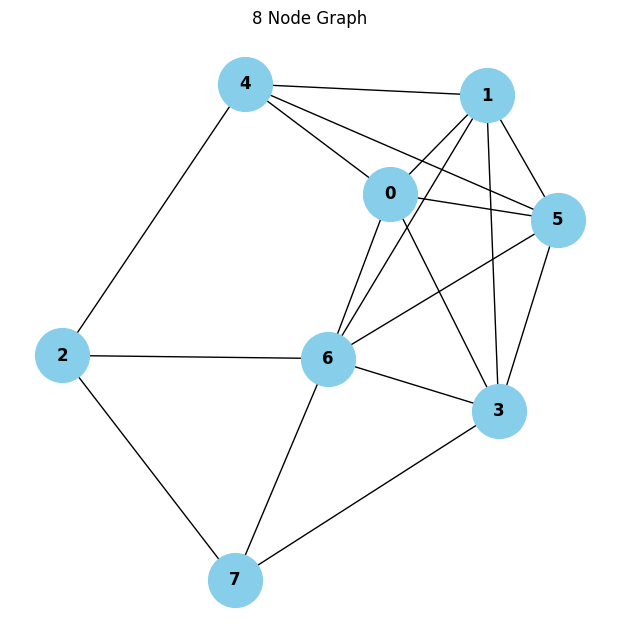

In [8]:
G = nx.Graph(A - np.eye(A.shape[0]))
print("RANK : ", np.linalg.matrix_rank(A))

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("8 Node Graph")
plt.show()

### Exponentially reducing distribution

In [9]:
# import numpy as np

# def hamming_weight(vector):
#     return sum(vector)

# def calculate_probability(alpha, vector):
#     return alpha ** hamming_weight(vector)

# def normalize_probabilities(alpha, vectors):
#     total_probability = sum(calculate_probability(alpha, vector) for vector in vectors)
#     return [calculate_probability(alpha, vector) / total_probability for vector in vectors]

# def generate_vectors(length):
#     return [[int(b) for b in format(i, '0' + str(length) + 'b')] for i in range(2**length)]

# def probs():
#     alpha = math.exp(1)
#     length = 8
#     vectors = generate_vectors(length)
#     probabilities = normalize_probabilities(alpha, vectors)
#     probabilities = reversed(probabilities)

#     s = 0
#     mp = {}
#     for vector, probability in zip(vectors, probabilities):
#         # if hamming_weight(vector) == 0:
#         #     print("Vector:", vector, "Probability:", 0, "Coefficient:", 0)    
#         v = "".join([str(i) for i in vector])
#         p = probability
#         c = p**0.5
#         mp[v] = c
#         # print("Vector:", "".join([str(i) for i in vector]), "Probability:", probability, "Coefficient:", probability**0.5)
#         s += probability
#     print("SUM : ", s)
#     print(mp["00000000"], mp["11111111"])
#     return mp


In [10]:
# mp = probs()

In [11]:
# p = [0, 0, 1, 0, 1, 0, 0, 1]
# init_dist = list(mp.values())

# print(init_dist[:10], init_dist[-10:])

# # p = init_dist[0]**2
# sq_p = [i**2 for i in init_dist]

# add_all = sq_p[0] / len(sq_p)
# sq_p[0] = 0
# sq_p = [i + add_all for i in sq_p]

# init_dist = [i**0.5 for i in sq_p]

# qc = lights_out_solver(A, p, len(A), 6, init_dist)

In [12]:
# qasm_simulator = Aer.get_backend('qasm_simulator')
# transpiled_qc = transpile(qc, qasm_simulator)
# result = qasm_simulator.run(transpiled_qc, shots=10000).result()
# plot_histogram(result.get_counts(), figsize=(75, 20), title="Results for 8 Node graph with exponential input distribution")

In [13]:
# res = result.get_counts()
# print(res)

Normalization factor (deno): 3.6980320330018213
List of probabilities: [0, 0.13520704946250361, 0.0901380329750024, 0.06760352473125181, 0.054082819785001436, 0.0450690164875012, 0.038630585560715316, 0.033801762365625904, 0.030046010991667465]
Sum of squared probabilities: 1.0000000000000002
256
256


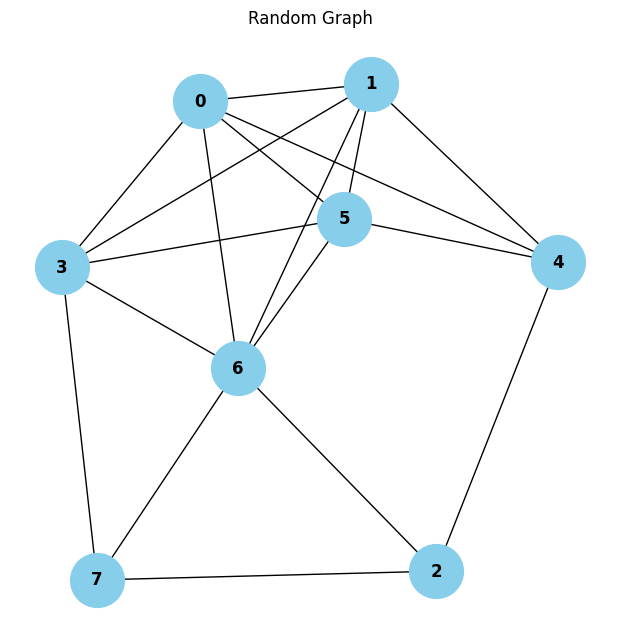

256
15.083097517817087
14.758600599107078


In [14]:
# Non Uniform Mapping parameter Hamming Weight
# (1/(hamming+1))/normalizer
n = 8

deno_sq = [(1 / (i+1))**2 * math.comb(n, i) for i in range(n+1)]
deno_sq[0] = 0
deno_sq = sum(deno_sq)
deno = math.sqrt(deno_sq)

p = []
for i in range(n+1):
    prob = 1 / ((i + 1) * deno)
    if i == 0:
        prob = 0
    p.append(prob)

print("Normalization factor (deno):", deno)
print("List of probabilities:", p)

s = 0
for idx, i in enumerate(p):
    s += i**2 * float(math.comb(n, idx))
print("Sum of squared probabilities:", s)

def count_ones(bit_string):
    return bit_string.count('1')

def generate_bit_strings(n):
    bit_strings = []
    for i in range(2**n):
        bit_string = bin(i)[2:].zfill(n)
        bit_strings.append(bit_string)
    return bit_strings

def map_to_ones_count(bit_strings):
    ones_count_map = {}
    for bit_string in bit_strings:
        ones_count = count_ones(bit_string)
        if bit_string not in ones_count_map:
            ones_count_map[bit_string] = ones_count
    return ones_count_map

bit_strings = generate_bit_strings(n)
print(len(bit_strings))
ones_count_map = map_to_ones_count(bit_strings)
print(len(ones_count_map))
prob_map = {"00000000": [0, 0]}
state = []
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("Random Graph")
plt.show()
for string, count in ones_count_map.items():
        state.append(p[count])
        prob_map[string] = []
        prob_map[string].append(p[count])
        prob_map[string].append(count_ones(string))
        # print(f"{string} -> {count} -> {p[count]}")

s = 0
for i in state:
    s += i**2
print(len(state))

print(sum(state))
print(sum(state) - 3*0.0901380329750024 - 0.054082819785001436)

In [15]:
s = 0
# print(prob_map)
for k in prob_map:
    s += prob_map[k][0]**2
print(s)

1.0000000000000033


In [16]:
p = [0, 0, 1, 0, 1, 0, 0, 1] # Initial on/off
# state is the probs
# qc = lights_out_solver(A, p, len(A), 1, state)

In [17]:
# qasm_simulator = Aer.get_backend('qasm_simulator')
# transpiled_qc = transpile(qc, qasm_simulator)
# result = qasm_simulator.run(transpiled_qc, shots=1000).result()
# plot_histogram(result.get_counts(), figsize=(75, 20), title="Results for 8 Node graph with linear input distribution")

In [18]:
# print(result.get_counts())

In [19]:
# result.get_unitary(qc)

In [20]:
# results = []
# for idx in range(5):
#     qc = lights_out_solver(A, p, len(A), idx, state)
#     qasm_simulator = Aer.get_backend('qasm_simulator')
#     transpiled_qc = transpile(qc, qasm_simulator)
#     result = qasm_simulator.run(transpiled_qc, shots=4096).result()
#     results.append(result.get_counts())
#     # plot_histogram(result.get_counts(), figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {idx} runs.")

In [21]:
# plot_histogram(results[0], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {0} runs.")

In [22]:
# plot_histogram(results[1], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {1} runs.")

In [23]:
# plot_histogram(results[2], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {2} runs.")

In [24]:
# plot_histogram(results[3], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {3} runs.")

In [25]:
# plot_histogram(results[4], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {4} runs.")

In [26]:
# results = []
# for idx in [5, 6, 7, 8, 9]:
#     qc = lights_out_solver(A, p, len(A), idx, state)
    # qasm_simulator = Aer.get_backend('qasm_simulator')
    # transpiled_qc = transpile(qc, qasm_simulator)
    # result = qasm_simulator.run(transpiled_qc, shots=4096).result()
#     results.append(result.get_counts())
#     # plot_histogram(result.get_counts(), figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {idx} runs.")

In [27]:
# plot_histogram(results[0], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {5} runs.")

In [28]:
# plot_histogram(results[1], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {6} runs.")

In [29]:
# plot_histogram(results[2], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {7} runs.")

In [30]:
# plot_histogram(results[3], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {8} runs.")

In [31]:
# plot_histogram(results[4], figsize=(75, 20), title=f"Results for 8 Node graph with linear input distribution and {9} runs.")

In [35]:
n_count = 4096.0
iter = 6
qc = lights_out_solver(A, p, len(A), iter, state)
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc, shots=n_count).result()

In [42]:
cnts = result.get_counts()
cnts = {k: v for k, v in cnts.items() if v >= 8}
cnts = dict(sorted(
    cnts.items(),
    key=lambda item: 1.0/item[0].count('1')  # Hamming weight is the count of '1's in the key
))
keys = list(cnts.keys())
vals = list(cnts.values())
vals = [val/n_count for val in vals]

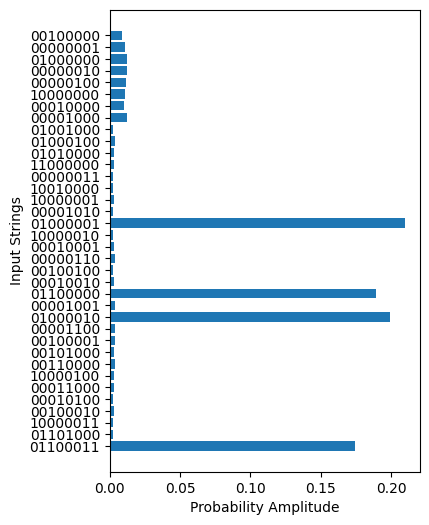

In [43]:
plt.figure(figsize=(4, 6))
plt.barh(keys, vals)
plt.xlabel("Probability Amplitude")
plt.ylabel("Input Strings")
plt.show()